# [GLIDE](https://arxiv.org/abs/2112.10741)
## Towards Photorealistic Image Generation and Editing with Text-Guided Diffusion Models

This Colab notebook shows how to use GLIDE (filtered) + a filtered noise-aware CLIP model to produce images conditioned on text prompts.

- Author: Manuel Romero ([mrm8488](https://twitter.com/mrm8488)) NLP/NLG Engineer at [Narrativa](https://narrativa.com/)


### How to run it:
1. Go to "Runtime" > "Change runtime" and Change hardware acceleration to GPU.
2. Run every cell in the notebook and set the `prompt`in the form (Set Sampling Parameters) as you wish.

In [1]:
#@title Clone and install
%%capture
!git clone https://github.com/openai/glide-text2im.git

%cd /content/glide-text2im/
!pip install -e .
!pip install ftfy
from PIL import Image
from IPython.display import display
import torch as th
import torch.nn as nn

In [2]:
#@title Imports
from PIL import Image
from IPython.display import display
import torch as th
import torch.nn as nn

from glide_text2im.clip.model_creation import create_clip_model
from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler,
)
from glide_text2im.tokenizer.simple_tokenizer import SimpleTokenizer

In [3]:
#@title Set the device
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

In [4]:
#@title Create base and upsampler models
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))


options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

  0%|          | 0.00/1.54G [00:00<?, ?iB/s]

total base parameters 385030726


  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

total upsampler parameters 398361286


In [5]:
#@title Create CLIP model
clip_model = create_clip_model(device=device)
clip_model.image_encoder.load_state_dict(load_checkpoint('clip/image-enc', device))
clip_model.text_encoder.load_state_dict(load_checkpoint('clip/text-enc', device))

  0%|          | 0.00/346M [00:00<?, ?iB/s]

  0%|          | 0.00/287M [00:00<?, ?iB/s]

<All keys matched successfully>

In [6]:
#@title 
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    img = Image.fromarray(reshaped.numpy())
    img.save("/content/glide_out.png", format="png")
    display(img)

In [13]:
#@title Set Sampling Parameters
prompt = "A fractal" #@param {type: "string"}
batch_size =  8 #@param {type: "number"}
guidance_scale = 3.0 #@param {type: "number"}
upsample_temp = 0.997 #@param {type: "number"}

  0%|          | 0/100 [00:00<?, ?it/s]

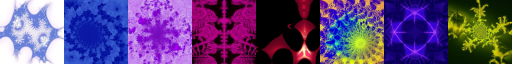

  0%|          | 0/27 [00:00<?, ?it/s]

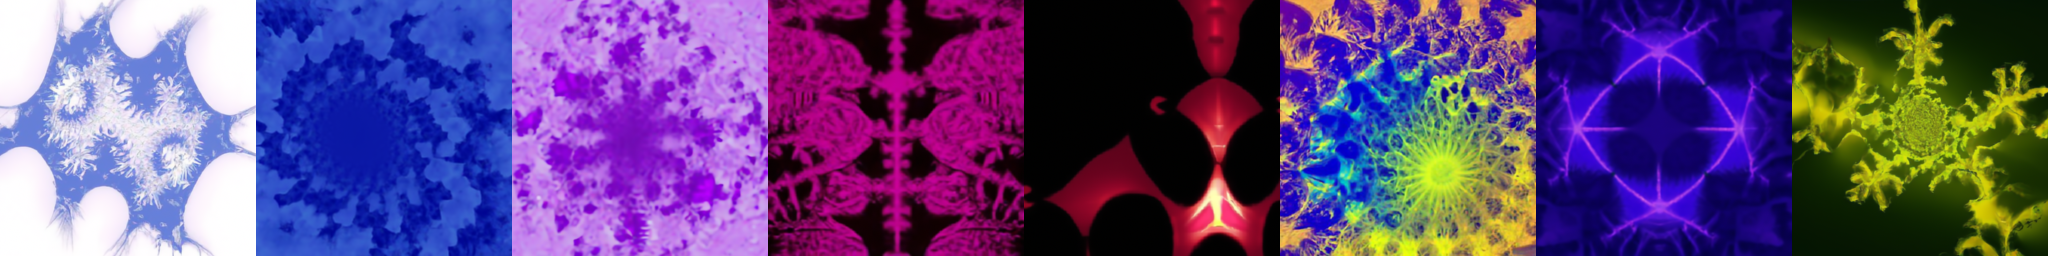

In [14]:
#@title Generate
##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor([tokens] * batch_size, device=device),
    mask=th.tensor([mask] * batch_size, dtype=th.bool, device=device),
)

# Setup guidance function for CLIP model.
cond_fn = clip_model.cond_fn([prompt] * batch_size, guidance_scale)

# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model,
    (batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=cond_fn,
)
model.del_cache()

# Show the output
show_images(samples)

##############################
# Upsample the 64x64 samples #
##############################

tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()

# Show the output
show_images(up_samples)

In [ ]:
#@title Download (Optional)
from google.colab import files
files.download('/content/glide_out.png') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>